# SARIMA

## Dependencies

In [10]:
from utils import create_session, mape, csv_to_df_1
import time

# Essentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Model specific
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

## Data Preparation

#### Retrieving Retail Store data from snowflake account
Compared to the original kaggle dataset, the data has been cutoff at the first date of an offer. 
Kaggle link: https://www.kaggle.com/competitions/acquire-valued-shoppers-challenge/data

From previous experiments I have decided to use Z-score to identify outliers and set them equal to the mean. 

In [6]:
session = create_session()

DatabaseError: 250001 (08001): Failed to connect to DB: WCGIOOU-ZN56920.snowflakecomputing.com:443. Your free trial has ended and all of your virtual warehouses have been suspended. Add billing information in the Snowflake web UI to continue using the full set of Snowflake features.

In [2]:
# in snowflake
df = session.table("company_revenue_time_series_1")#.collect()
df = df.to_pandas()

NameError: name 'session' is not defined

In [3]:
# local
df = csv_to_df_1()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2012-03-29,111256.45
1,2012-03-31,186687.38
2,2012-04-12,112072.74
3,2012-04-17,114506.48
4,2012-04-24,112192.12


In [4]:


df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

# Outliers = mean
threshold = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std
outlier_index = np.where(z_scores > threshold)[0]
df['y'] = np.where(np.abs(z_scores) > threshold, mean, df['y'])

print(df.head())
print(df.info())

# Train / test split
cutoff = round(len(df) * 0.8)

train = df[:cutoff]
test = df[cutoff:]


          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      363 non-null    datetime64[ns]
 1   y       363 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None


#### Display data

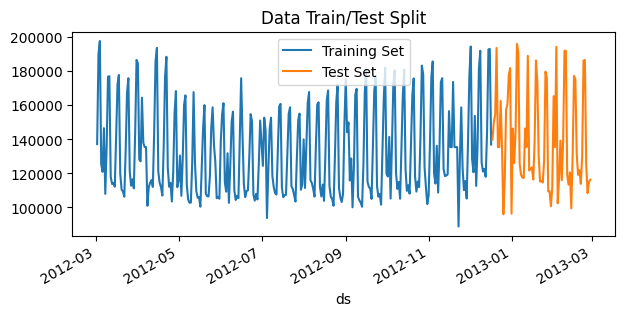

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
train.plot(x='ds', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(x='ds', ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])

plt.show()

## Evaluate Stationarity

The sarima model relies on the data being stationary to satisfy certain mathematical properties in the model.

What does it mean for the data to be stationary?
It means that the distribution does not change over time. In simple terms, you should be able to take two histograms from two random intervals and they are equal. 
Then there is:
- no trend to the data
- the variance is constant
- autocorrelation is constant, meaning one varible does not depend on the previous

As you see in the plot above there is a slight trend to the data, and perhaps some increase in variance. That means it is unlikely to be stationary. 

In addition to inspecting the graph for trend and change in variance, we can use the statistical tests KPSS and Adfuller to check for stationarity. If they both believe that the data is stationary we can be fairly certain it is.

In [6]:
result = adfuller(train['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

print(80*'-')

statistic, p_value, n_lags, critical_values = kpss(train['y'])

print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF Statistic: -1.9099765505569357
p-value: 0.3273824796889653
Result: The series is not stationary
--------------------------------------------------------------------------------
KPSS Statistic: 0.3972877490446918
p-value: 0.07832424610142596
Result: The series is stationary


#### Differencing

As the data does not pass the ADF test, I need to transform it. In this case I have chosen to do so using differencing. Since the data is seasonal I have chosen the seasonal differencing method. If the data is not stationary after I can apply first-order differencing instead.

Differencing is simply subtracting the previous value from each. Hence, the first value in the resulting df will be NA as there is nothing to sbutract it with. Drop it. 

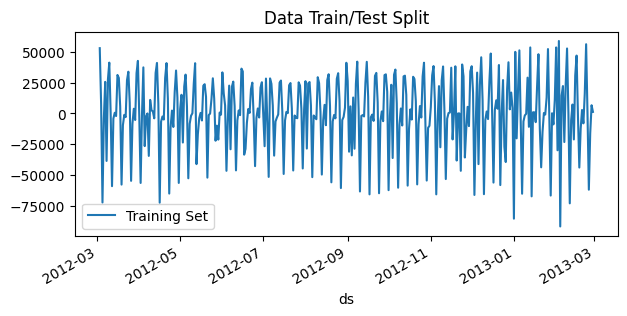

In [7]:
from statsmodels.tsa.statespace.tools import diff
seasonal_diff = df.copy()
seasonal_diff['y'] = diff(df['y'], k_diff=1, seasonal_periods=7)
seasonal_diff = seasonal_diff.dropna()

fig, ax = plt.subplots(figsize=(7, 3))
seasonal_diff.plot(x='ds', ax=ax, label='Training Set', title='Data Train/Test Split')
ax.legend(['Training Set', 'Test Set'])


In [8]:
result = adfuller(seasonal_diff['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

print(80*'-')

statistic, p_value, n_lags, critical_values = kpss(seasonal_diff['y'])

print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF Statistic: -10.750156127213252
p-value: 2.678093817131521e-19
Result: The series is stationary
--------------------------------------------------------------------------------
KPSS Statistic: 0.22368108083322916
p-value: 0.1
Result: The series is stationary


/var/folders/5c/z7z53cld06bcgtmj8dz43mhm0000gp/T/ipykernel_52332/3348695566.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(seasonal_diff['y'])


Looking at the graph and reading the KPSS and Adfuller results we can now conclude that the data is stationary after on seasonal difference. 

#### Plotting acf and pacf

The acf (autocorrelation function) measures the correlation between the time series and a laagged version of itself. E.g. if there is a signficiant spike at at lag x, it means that the values in the time series are influenced by the value that many lags back. 

The pacf (partial autocorrelation function) measures the same thing, but removes the effect of all the time lags in between the ones you are measuring. 

The acf and pacf can be used to determine the parameters in our SARIMA model. A SARIMA model is the same as an ARIMA model, but with a seasonal component. Hence, the p and d term in the SARIMA model is selected like the p and d term in the ARIMA model. We can do that using the acf and pacf graph as described below. There is one change, and that is for a seasonal arima, we can only evaluate the lags up to the end of a season. So for this model taht is weekly seasonal on daily data, we can only look at the lags up until 7.


The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:
- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag in the PACF, but none beyond lag p

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:
- the PACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in the ACF, but none beyond lag q.

Take notice in the explanation above that if you select a p, q = 0, and the other way around. 

Similarily we can look at the acf and pacf graphs to choose P and Q for the seasonal component. Same thought behind it, but this time you only look at the seasonal lags. So for this example we look at lag 7, 14, 21, ... and so on. 

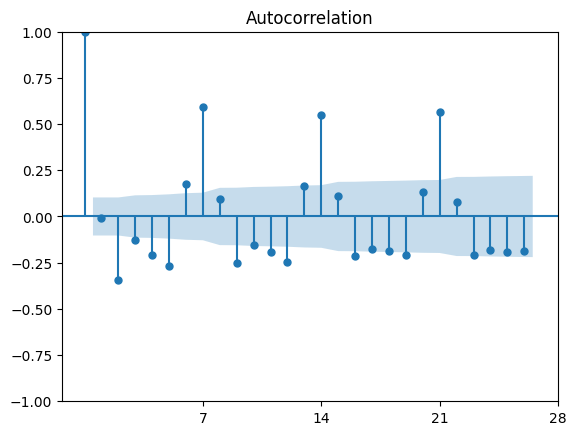

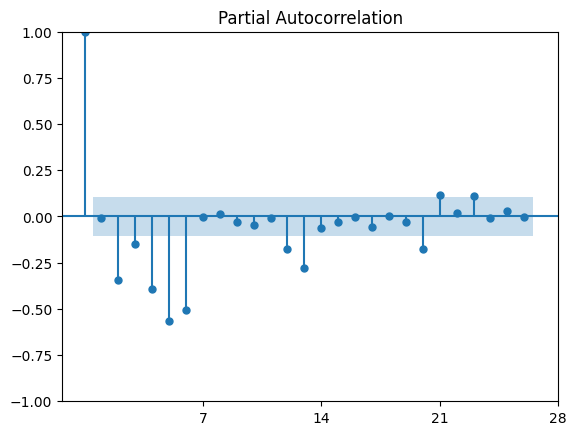

In [9]:
plot_acf(seasonal_diff['y'])
plt.xticks([7, 14, 21, 28]) # specify xticks for readability

plot_pacf(seasonal_diff['y'])
plt.xticks([7, 14, 21, 28]) # specify xticks for readability
plt.show()

From the graphs above we select

D = 1, because we did one seasonal difference on the data
d = 0, because we did no first-order difference on the data

significant = otuside confidece interval. 

P = 0, because all lags are significant and little change on acf plot
Q = 1, because there are is one siginificant ish spike at the lag intervals in the pacf plot

p = 3 significant, 2 fairly significant 
q = 5 significant,
Since one can choose to do both q and p we can try both and see what returns the best result. 

s = 7, because it is the seasonal period

## Fitting the model

In [12]:
s_time = time.time()
# Fit a SARIMA model versino 1 with q = 5
p = 0  # AR order
d = 0  # Non-seasonal differencing # first difference? x difference 
q = 5  # MA order
P = 0  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
s = 7  # Seasonal period (e.g., 12 for monthly data)
x
model = SARIMAX(train['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()
e_time = time.time()
print(f"Total fit time: {e_time - s_time}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09241D+01    |proj g|=  4.07625D-01

At iterate    5    f=  1.07992D+01    |proj g|=  1.13304D-02


 This problem is unconstrained.



At iterate   10    f=  1.07987D+01    |proj g|=  5.70600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   1.529D-05   1.080D+01
  F =   10.798748662056228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Total fit time: 0.414431095123291


Number of days forecasted: 73
Total forecasting time: 0.053999900817871094

MAPE: 10.08%



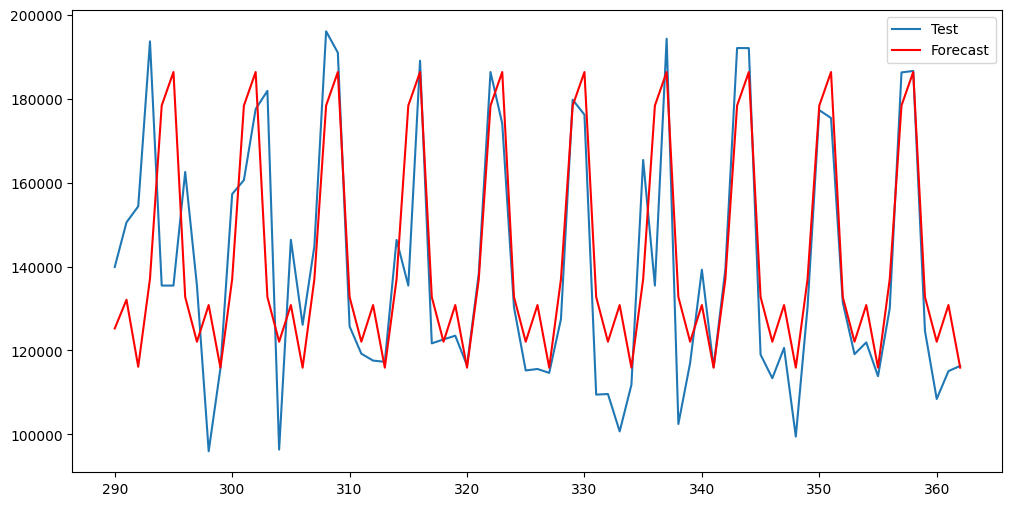

In [14]:
n_steps = len(test['y'])
print(f"Number of days forecasted: {len(test['y'])}")

s_time = time.time()

forecast = model_fit.forecast(steps=n_steps)

e_time = time.time()
print(f"Total forecasting time: {e_time - s_time}")

# calculate error
error = mape(test['y'], forecast)
print(f"\nMAPE: {error}%\n")

plt.figure(figsize=(12, 6))
plt.plot(test['y'], label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [15]:
# Fit a SARIMA model versino 2 with p = 3
p = 3  # AR order
d = 0  # Non-seasonal differencing # first difference? x difference 
q = 0  # MA order
P = 0  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
s = 7  # Seasonal period (e.g., 12 for monthly data)

s_time = time.time()

model = SARIMAX(train['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

e_time = time.time()
print(f"Total train time: {e_time - s_time}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08515D+01    |proj g|=  3.07429D-01

At iterate    5    f=  1.07856D+01    |proj g|=  8.39571D-03

At iterate   10    f=  1.07855D+01    |proj g|=  2.32077D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.510D-05   1.079D+01
  F =   10.785511554702790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Total train time: 0.25047898292541504


 This problem is unconstrained.


Number of days forecasted: 73
Total forecasting time: 0.03323197364807129

MAPE: 10.14%



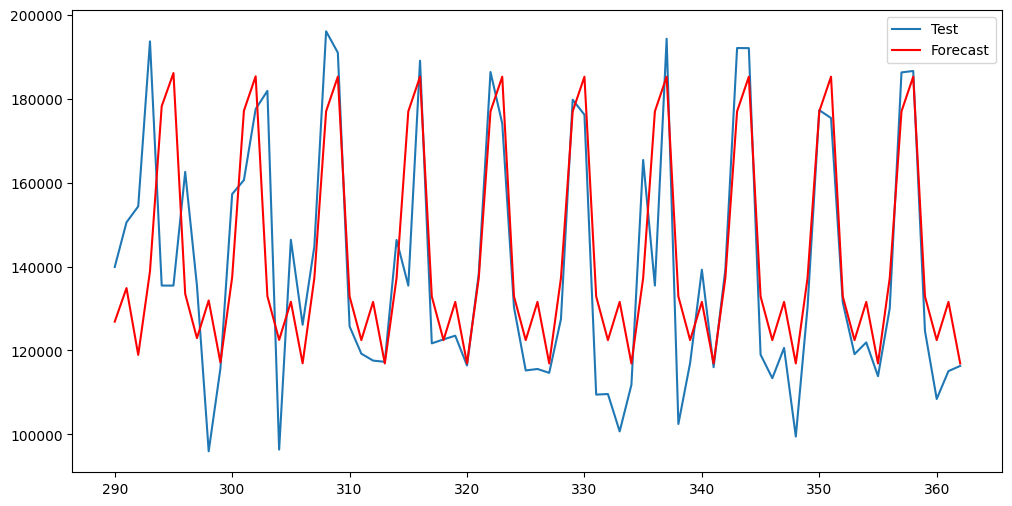

In [16]:
n_steps = len(test['y'])
print(f"Number of days forecasted: {len(test['y'])}")

s_time = time.time()

forecast = model_fit.forecast(steps=n_steps)

e_time = time.time()
print(f"Total forecasting time: {e_time - s_time}")

# calculate error
error = mape(test['y'], forecast)
print(f"\nMAPE: {error}%\n")

plt.figure(figsize=(12, 6))
plt.plot(test['y'], label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

As you can see from the two models and corresponding results above, the sarima models achieve an accuracy of around 9% MAPE and p=3 seems to be a slightly better model. 

### Automated Sarima
The process of automatically selecting the parameters for the model is tedious, and alchemish. There is an automated sarima version that will do it for you as well. Let's see what results it gets.

In [18]:
import pmdarima as pm
from pmdarima import model_selection

In [19]:
s_time = time.time()

auto_sarima = pm.auto_arima(train['y'], error_action='ignore', trace=True, D=1,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, m=7)
# m=s
e_time = time.time()
print(f"Total search time: {e_time - s_time}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=6256.055, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6359.160, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6289.816, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6277.143, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6357.245, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=6254.157, Time=0.22 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=6333.602, Time=0.13 sec
 ARIMA(2,0,2)(0,1,2)[7] intercept   : AIC=6256.157, Time=0.67 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=6287.272, Time=0.28 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=6254.575, Time=1.09 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=6257.377, Time=0.28 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=6274.564, Time=0.22 sec
 ARIMA(3,0,2)(0,1,1)[7] intercept   : AIC=6254.399, Time=0.49 sec
 ARIMA(2,0,3)(0,1,1)[7] intercept   : AIC=6250.516, Time=0.34 sec
 ARIMA(2,0,3)(0,1,0)[7] intercept

Best model:  ARIMA(5,0,0)(0,1,1)[7] intercept
Total fit time: 129.937 seconds
With iter=100. 

Fitting and testing a model with those parameters we find that it has almost the same performance as teh manually selected model, only slightly worse. In addition, it only took about 2 minutes to run wheras plotting and reading the acf and pacf would take somewaht longer. Personally, I would do it manually and then do a check with maybe 100 iterations on the auto select to compare. It is nice to benchmark your parameter choices like that.

In [22]:
# Fit a SARIMA model versino 2 with p = 3
p = 5  # AR order
d = 0  # Non-seasonal differencing # first difference? x difference 
q = 0  # MA order
P = 0  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
s = 7  # Seasonal period (e.g., 12 for monthly data)

s_time = time.time()

model = SARIMAX(train['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

e_time = time.time()
print(f"Total train time: {e_time - s_time}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08717D+01    |proj g|=  3.76264D-01

At iterate    5    f=  1.07725D+01    |proj g|=  5.33488D-03

At iterate   10    f=  1.07724D+01    |proj g|=  1.60162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     12      1     0     0   1.602D-05   1.077D+01
  F =   10.772382031866483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Total train time: 0.2438220977783203


 This problem is unconstrained.


Total forecasting time: 0.005845069885253906

MAPE: 10.42%



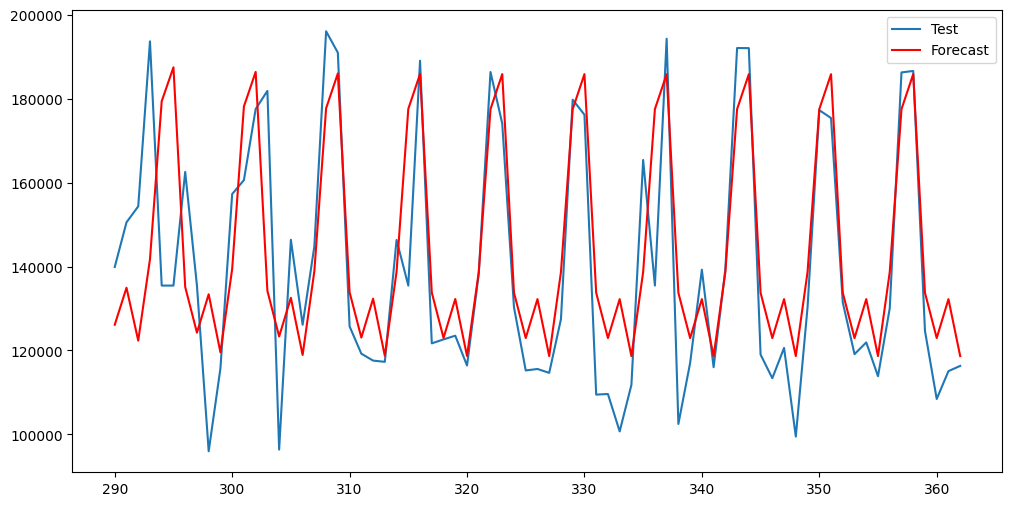

In [23]:

s_time = time.time()

n_steps = len(test['y'])
forecast = model_fit.forecast(steps=n_steps)

e_time = time.time()
print(f"Total forecasting time: {e_time - s_time}")


# calculate error
error = mape(test['y'], forecast)
print(f"\nMAPE: {error}%\n")

plt.figure(figsize=(12, 6))
plt.plot(test['y'], label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Resources
- Excellent chapter on (S)ARIMA: https://otexts.com/fpp3/arima.html 
- Good article on adfuller v kpss: https://medium.com/@tannyasharma21/comparision-study-of-adf-vs-kpss-test-c9d8dec4f62a